In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


%matplotlib inline
sns.set(style="whitegrid")

In [9]:
# data load
train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()

Train shape: (67727, 25)
Test shape: (10324, 25)


,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,MLSAreaMajor,AttachedGarageYN,ParkingTotal,...,FireplaceYN,Stories,Levels,LotSizeArea,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet
0,True,False,2025-06-13,890000.0,34.264692,-117.221040,3000.0,287A - Arrowhead Woods,True,2.0,...,True,2.0,Two,9600.0,True,2.0,Rim of the World,92352,0.0,9600.0
1,True,False,2025-06-30,1876384.0,34.107983,-118.390320,1800.0,C03 - Sunset Strip - Hollywood Hills West,False,1.0,...,True,2.0,Two,10400.0,False,2.0,San Ramon Valley,90046,0.0,10400.0
2,False,False,2025-06-30,4820000.0,37.567434,-122.388226,4270.0,699 - Not Defined,True,3.0,...,True,1.0,Two,22505.0,False,3.0,Other,94010,0.0,22505.0
3,True,False,2025-06-30,865000.0,33.906058,-117.777782,1442.0,85 - Yorba Linda,True,2.0,...,True,1.0,One,4800.0,False,2.0,Placentia-Yorba Linda Unified,92886,0.0,4800.0
4,False,False,2025-06-30,875000.0,37.705919,-122.059421,1086.0,699 - Not Defined,True,4.0,...,True,1.0,One,5500.0,False,4.0,Placentia-Yorba Linda Unified,94546,138.0,5500.0


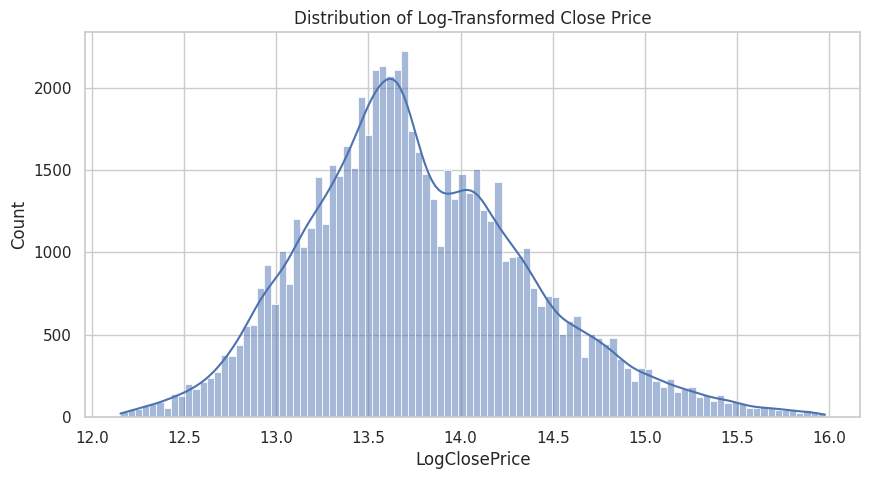

In [10]:
# 종속 변수(ClosePrice) 로그 변환
train['LogClosePrice'] = np.log1p(train['ClosePrice'])
test['LogClosePrice'] = np.log1p(test['ClosePrice'])

# 변환 후 분포 확인
plt.figure(figsize=(10, 5))
sns.histplot(train['LogClosePrice'], kde=True)
plt.title('Distribution of Log-Transformed Close Price')
plt.show()

In [11]:
# 분석에 사용할 특성(Features) 선택
features = ['LivingArea', 'BedroomsTotal', 'BathroomsTotalInteger', 'LotSizeAcres', 'YearBuilt']

X_train = train[features]
y_train = train['LogClosePrice']

X_test = test[features]
y_test = test['LogClosePrice']

# 결측치가 있다면 0으로 채움 (전처리 단계에 따라 조정 가능)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [12]:
# 모델 생성 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 회귀 계수(Coefficients) 확인
coeff_df = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
print("Model Coefficients:")
print(coeff_df)

Model Coefficients:
                       Coefficient
LivingArea                0.000313
BedroomsTotal            -0.016813
BathroomsTotalInteger     0.170707
LotSizeAcres             -0.000004
YearBuilt                -0.007796


Root Mean Squared Error: 0.4614
R-squared Score: 0.4419


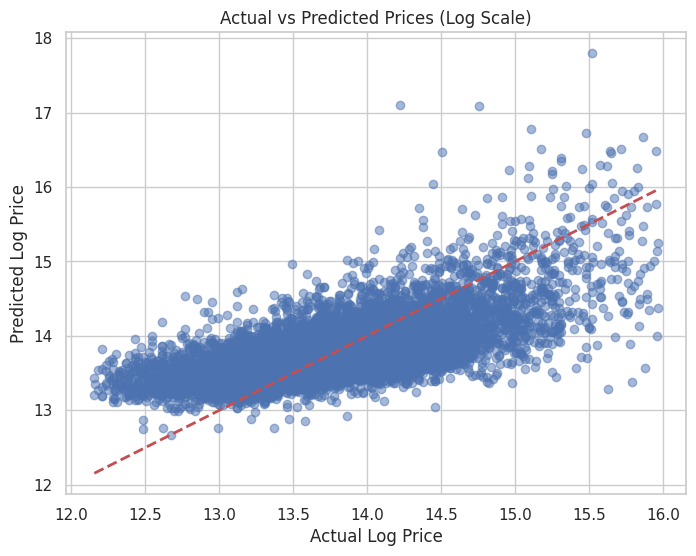

In [13]:
# 예측 수행
y_pred_log = model.predict(X_test)

# 평가 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2 = r2_score(y_test, y_pred_log)

print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# 실제값 vs 예측값 시각화
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_log, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.title('Actual vs Predicted Prices (Log Scale)')
plt.show()

In [15]:
# (exp - 1)
final_pred = np.expm1(y_pred_log)
final_actual = np.expm1(y_test)

comparison_df = pd.DataFrame({'Actual': final_actual, 'Predicted': final_pred})
comparison_df['Abs_Error'] = abs(comparison_df['Actual'] - comparison_df['Predicted'])

print("Final Predictions Snippet (Original Currency):")
print(comparison_df.head())

Final Predictions Snippet (Original Currency):
      Actual     Predicted     Abs_Error
0  1998000.0  9.147138e+05  1.083286e+06
1  2214421.0  1.920661e+06  2.937598e+05
2  1200000.0  7.346919e+05  4.653081e+05
3  3100000.0  8.398190e+05  2.260181e+06
4  2900000.0  1.093490e+06  1.806510e+06


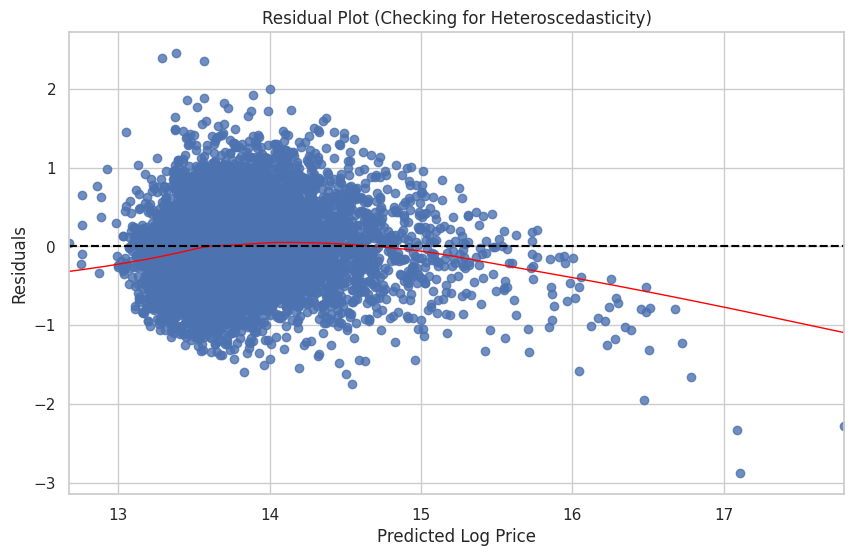

In [16]:
# 잔차 계산
residuals = y_test - y_pred_log

plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_log, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Log Price')
plt.ylabel('Residuals')
plt.title('Residual Plot (Checking for Heteroscedasticity)')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

## Begin Steven
## Evaluation on this model


### Evaluation on LOG Scale


In [20]:
# R² (Log Scale)
r2_log = r2_score(y_test, y_pred_log)

# MAPE (Log Scale) — not very interpretable, but computed for comparison
mape_log = np.mean(np.abs((y_test - y_pred_log) / y_test)) * 100

# MdAPE (Log Scale)
mdape_log = np.median(np.abs((y_test - y_pred_log) / y_test)) * 100

### Evaluation on Original scale

In [21]:
# R² (Original Scale)
r2_original = r2_score(final_actual, final_pred)

# MAPE (Original Scale)
mape_original = np.mean(np.abs((final_actual - final_pred) / final_actual)) * 100

# MdAPE (Original Scale)
mdape_original = np.median(np.abs((final_actual - final_pred) / final_actual)) * 100

In [22]:
print("===== LOG SCALE PERFORMANCE =====")
print(f"R² (Log): {r2_log:.4f}")
print(f"MAPE (Log): {mape_log:.2f}%")
print(f"MdAPE (Log): {mdape_log:.2f}%\n")

print("===== ORIGINAL SCALE PERFORMANCE =====")
print(f"R² (Original): {r2_original:.4f}")
print(f"MAPE (Original): {mape_original:.2f}%")
print(f"MdAPE (Original): {mdape_original:.2f}%")

===== LOG SCALE PERFORMANCE =====
R² (Log): 0.4419
MAPE (Log): 2.60%
MdAPE (Log): 2.13%

===== ORIGINAL SCALE PERFORMANCE =====
R² (Original): -0.1383
MAPE (Original): 39.64%
MdAPE (Original): 28.98%


## Interpretation

- **R²(Log scale) :** Indicates how well the model explains variance in log transform of the target.    
  - 44.2% of variance explained, meaning the selected features capture a moderate amount of log price variability.

- **MAPE (Mean Absolute Percentage Error):** Measures the average percentage error of predictions.  
  - 2.60% deviation on average. indicating that the model's predictions are very close to the actual prices on log-scale average.  

- **MdAPE (Median Absolute Percentage Error):** Median percentage error, more robust to extreme prices.  
  - 2.13% typical deviation.  
  - indicating that the model's predictions are very close to the actual prices on log-scale average.

## END Steven

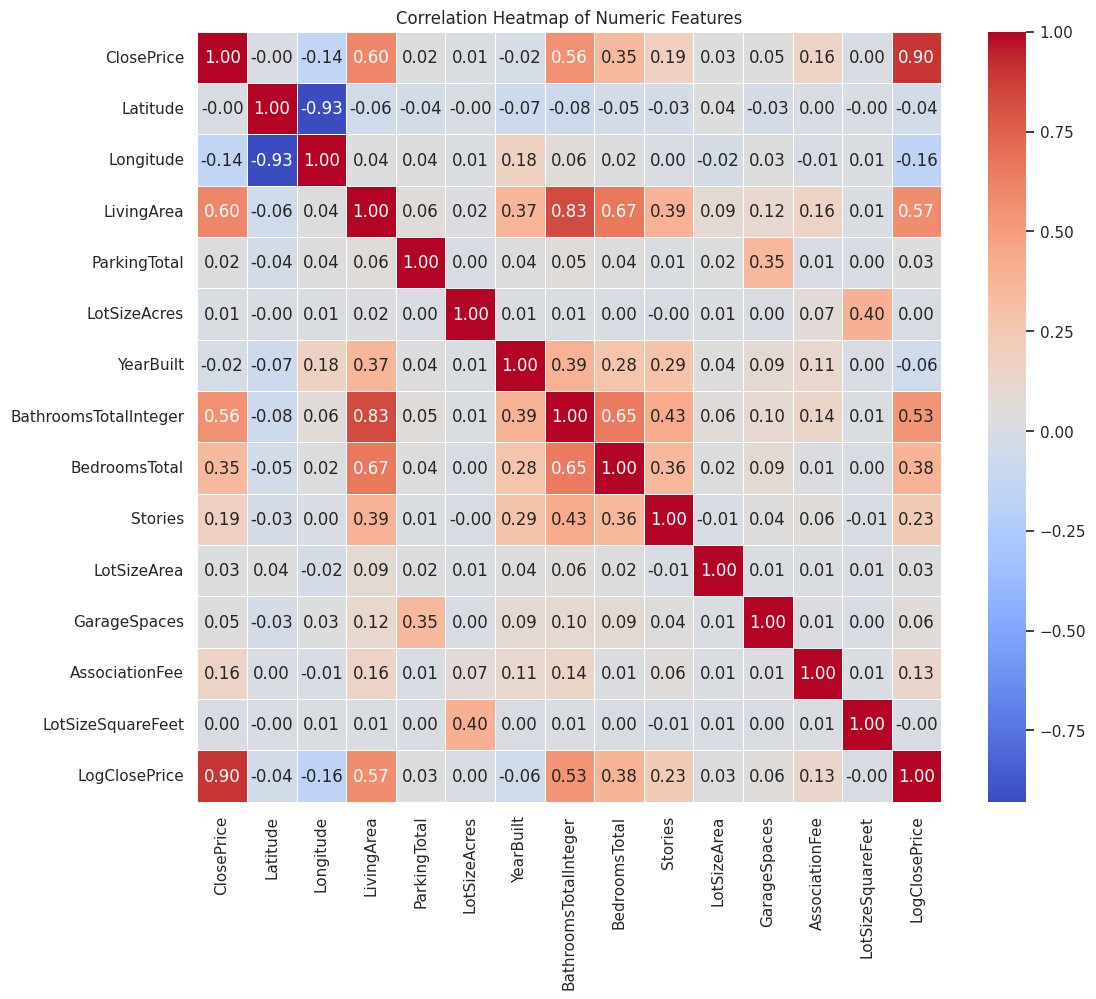

In [23]:
# 수치형 변수들 간의 상관관계 확인
plt.figure(figsize=(12, 10))
numeric_cols = train.select_dtypes(include=[np.number]).columns
corr_matrix = train[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [24]:
# 범주형 변수 처리 (예: ViewYN, NewConstructionYN 등)
categorical_features = ['ViewYN', 'PoolPrivateYN', 'NewConstructionYN', 'FireplaceYN']

# 학습 및 테스트 데이터 결합 후 더미 변수 생성 (컬럼 일치를 위해)
X_train_ext = pd.get_dummies(train[features + categorical_features], drop_first=True)
X_test_ext = pd.get_dummies(test[features + categorical_features], drop_first=True)

# Check the
X_train_ext.isna().sum().sum()



np.int64(0)

In [25]:
# 모델 재학습
model_v2 = LinearRegression()
model_v2.fit(X_train_ext, y_train)

y_pred_v2 = model_v2.predict(X_test_ext)
print(f"Improved R2 Score: {r2_score(y_test, y_pred_v2):.4f}")

Improved R2 Score: 0.4520


In [26]:
from sklearn.model_selection import cross_val_score

# 5-Fold 교차 검증 수행
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {cv_scores.mean():.4f}")

Cross-Validation R2 Scores: [0.43563235 0.43065793 0.41889328 0.43389608 0.4501065 ]
Mean CV R2 Score: 0.4338


In [27]:
import joblib

# Model SAVED AS
import joblib

joblib.dump(model_v2, 'linear_regression_house_model.pkl')
joblib.dump(X_train_ext.columns, 'model_columns.pkl')

print("Model and column structure saved.")

Model and column structure saved.


# BEGIN Steven

## Load Model and Columns

In [31]:
loaded_model = joblib.load('linear_regression_house_model.pkl')
model_columns = joblib.load('model_columns.pkl')

## Recreate Train/Test Matrices

In [39]:
# Recreate train matrix
X_train_ext = pd.get_dummies(train[features + categorical_features], drop_first=True)
X_train_ext = X_train_ext.reindex(columns=model_columns, fill_value=0)

# Recreate test matrix
X_test_ext = pd.get_dummies(test[features + categorical_features], drop_first=True)
X_test_ext = X_test_ext.reindex(columns=model_columns, fill_value=0)

In [40]:
import numpy as np
from sklearn.metrics import r2_score

# -----------------------------
# Predictions
# -----------------------------
# Log scale predictions
y_pred_log = loaded_model.predict(X_test_ext)
y_test_log = y_test  # already log-transformed

# Original scale predictions
y_pred_orig = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test_log)

# -----------------------------
# Evaluation on LOG scale
# -----------------------------
r2_log = r2_score(y_test_log, y_pred_log)
mape_log = np.mean(np.abs((y_test_log - y_pred_log) / y_test_log)) * 100
mdape_log = np.median(np.abs((y_test_log - y_pred_log) / y_test_log)) * 100

# -----------------------------
# Evaluation on ORIGINAL scale
# -----------------------------
r2_orig = r2_score(y_test_orig, y_pred_orig)
mape_orig = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100
mdape_orig = np.median(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

# -----------------------------
# Print Results
# -----------------------------
print("===== LOG SCALE PERFORMANCE =====")
print(f"R² (Log): {r2_log:.4f}")
print(f"MAPE (Log): {mape_log:.2f}%")
print(f"MdAPE (Log): {mdape_log:.2f}%\n")

print("===== ORIGINAL SCALE PERFORMANCE =====")
print(f"R² (Original): {r2_orig:.4f}")
print(f"MAPE (Original): {mape_orig:.2f}%")
print(f"MdAPE (Original): {mdape_orig:.2f}%")

===== LOG SCALE PERFORMANCE =====
R² (Log): 0.4520
MAPE (Log): 2.58%
MdAPE (Log): 2.09%

===== ORIGINAL SCALE PERFORMANCE =====
R² (Original): -0.0100
MAPE (Original): 39.10%
MdAPE (Original): 28.41%


In [41]:
print(baseline_results.to_markdown(index=False))

| Model                                    | Dependent Variable   | Features Used                                                       |   Train R² |   Test R² |   Train MAPE (%) |   Test MAPE (%) |   Train MdAPE (%) |   Test MdAPE (%) |
|:-----------------------------------------|:---------------------|:--------------------------------------------------------------------|-----------:|----------:|-----------------:|----------------:|------------------:|-----------------:|
| Linear Regression v2 (Extended Features) | ClosePrice           | features + ViewYN + PoolPrivateYN + NewConstructionYN + FireplaceYN |     0.4475 |     0.452 |              2.6 |            2.58 |              2.11 |             2.09 |




## Interpretation
### Log Scale Performance

- **R² (Log scale): 0.4520
Indicates that the model explains 45.2% of the variance in the log-transformed target, meaning the selected features capture a moderate amount of variability in log house prices.

- ** MAPE (Mean Absolute Percentage Error): 2.58%
On average, predictions deviate by only 2.58% in log space, showing the model fits the log-transformed values very closely.

- **MdAPE (Median Absolute Percentage Error): 2.09%
The typical (median) prediction error is just 2.09%, confirming that most predictions are highly accurate in log space and robust to extreme values.



## End Steven